<a href="https://colab.research.google.com/github/fa7ih/surucuyorgunluk/blob/main/Metriks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os
import shutil

# 1. Google Drive'ı bağla
drive.mount('/content/drive')

# 2. Kaynak ve hedef klasörleri belirt
source_dir = '/content/drive/My Drive/models'  # Google Drive'daki models klasörü
target_dir = '/content/modals'  # Colab içindeki hedef klasör

# 3. Hedef klasörü oluştur (eğer yoksa)
os.makedirs(target_dir, exist_ok=True)

# 4. Tüm dosyaları kopyala
for filename in os.listdir(source_dir):
    source_path = os.path.join(source_dir, filename)
    target_path = os.path.join(target_dir, filename)

    # Eğer dosya ise kopyala
    if os.path.isfile(source_path):
        shutil.copy2(source_path, target_path)
        print(f'Kopyalandı: {filename}')


Mounted at /content/drive
Kopyalandı: levit_model_fold_1.pth
Kopyalandı: levit_model_fold_3.pth
Kopyalandı: levit_model_fold_2.pth
Kopyalandı: levit_model_fold_4.pth
Kopyalandı: levit_model_fold_5.pth
Kopyalandı: vit_model_fold_1.pth
Kopyalandı: vit_model_fold_2.pth
Kopyalandı: vit_model_fold_3.pth
Kopyalandı: vit_model_fold_5.pth
Kopyalandı: vit_model_fold_4.pth


In [3]:
!#!/bin/bash
!curl -L -o /content/driver-drowsiness-dataset-ddd.zip \
  https://www.kaggle.com/api/v1/datasets/download/ismailnasri20/driver-drowsiness-dataset-ddd
!unzip -o /content/driver-drowsiness-dataset-ddd.zip -d /content
!rm /content/driver-drowsiness-dataset-ddd.zip
!echo "Dataset indirildi ve çıkarıldı."

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0092.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0093.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0094.png  
  inflating: /content/Driver 

In [7]:
import os
from sklearn.model_selection import train_test_split


data_dir = '/content/dataset'

categories = ['Drowsy', 'NonDrowsy']

all_filepaths = []
all_labels = []

for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            filepath = os.path.join(category_dir, filename)
            all_filepaths.append(filepath)
            all_labels.append(i)


train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

<ipython-input-13-1bbcf352bc19>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/models/levit_model_fold_5.pth')


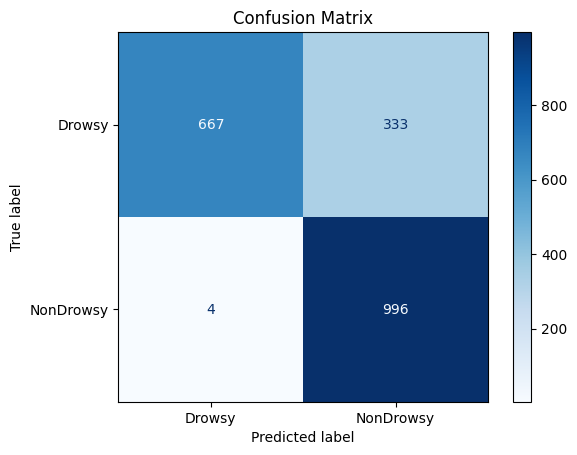

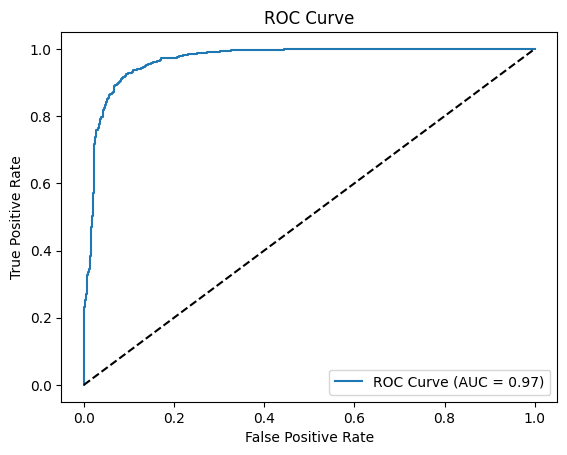

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from timm import create_model
import os
from PIL import Image

class SwinModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(SwinModel, self).__init__()
        self.backbone = create_model('levit_384', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.backbone(x)

model = SwinModel(num_classes=2)

state_dict = torch.load('/content/drive/MyDrive/models/levit_model_fold_5.pth')
new_state_dict = {}
for key in state_dict.keys():
    if key.startswith("backbone."):
        new_state_dict[key] = state_dict[key]
    else:
        new_state_dict[f"backbone.{key}"] = state_dict[key]

model.load_state_dict(new_state_dict)
model.eval()

dataset_path = '/content/dataset'

classes = ['Drowsy', 'NonDrowsy']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data = []
labels = []

for label, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_path):
        raise FileNotFoundError(f"Klasör bulunamadı: {class_path}")

    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)

        try:
            img = Image.open(file_path).convert('RGB')
            img_tensor = transform(img)
            data.append(img_tensor)
            labels.append(label)  # 0: Drowsy, 1: NonDrowsy
        except Exception as e:
            print(f"Hata oluştu: {file_path} -> {e}")

data = torch.stack(data)
labels = torch.tensor(labels)

test_dataset = TensorDataset(data, labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(preds.numpy())
        all_probs.extend(probs.numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Drowsy', 'NonDrowsy'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [17]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from timm import create_model
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from PIL import Image
from sklearn.model_selection import KFold
from google.colab import files

data_dir = '/content/dataset'
categories = ['Drowsy', 'NonDrowsy']

class CustomDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

all_filepaths = []
all_labels = []
for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        filepath = os.path.join(category_dir, filename)
        all_filepaths.append(filepath)
        all_labels.append(i)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(categories)

class DeiTModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(DeiTModel, self).__init__()
        self.backbone = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.backbone(x)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy, all_preds, all_labels

results = []

for fold, (train_index, val_index) in enumerate(kf.split(all_filepaths)):
    print(f"Fold {fold + 1}")

    train_filepaths = np.array(all_filepaths)[train_index]
    train_labels = np.array(all_labels)[train_index]
    val_filepaths = np.array(all_filepaths)[val_index]
    val_labels = np.array(all_labels)[val_index]

    train_dataset = CustomDataset(train_filepaths, train_labels, transform=transform)
    val_dataset = CustomDataset(val_filepaths, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

    model = DeiTModel(num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, val_preds, val_labels = validate(model, val_loader, criterion, device)

        precision = precision_score(val_labels, val_preds, average='binary')
        recall = recall_score(val_labels, val_preds, average='binary')
        f1 = f1_score(val_labels, val_preds, average='binary')
        specificity = recall_score(val_labels, val_preds, pos_label=0, average='binary')
        auc = roc_auc_score(val_labels, val_preds)

        results.append({
            'Fold': fold + 1,
            'Epoch': epoch + 1,
            'Train Loss': train_loss,
            'Val Loss': val_loss,
            'Accuracy': val_accuracy,
            'Precision': precision,
            'Recall (Sensitivity)': recall,
            'Specificity': specificity,
            'F1-Score': f1,
            'AUC': auc
        })

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}, F1-Score: {f1:.4f}, AUC: {auc:.4f}")

    save_path = f'/content/drive/MyDrive/models/vit_model_fold_{fold + 1}.pth'
    torch.save(model.state_dict(), save_path)
    print(f"Model fold {fold + 1} olarak {save_path} dosyasına kaydedildi.")
    files.download(save_path)

df_results = pd.DataFrame(results)
print(df_results)

df_results.to_csv('training_results.csv', index=False)
files.download('training_results.csv')


Fold 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 59.06 MiB is free. Process 3096 has 14.69 GiB memory in use. Of the allocated memory 14.16 GiB is allocated by PyTorch, and 400.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [4]:
import os
import random
import shutil

dataset_path = '/content/dataset/NonDrowsy'

files = os.listdir(dataset_path)

if len(files) > 1000:
    files_to_delete = random.sample(files, len(files) - 1000)

    for file in files_to_delete:
        file_path = os.path.join(dataset_path, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    print(f'{len(files_to_delete)} dosya silindi.')
else:
    print('Drowsy klasöründe zaten 1000 veya daha az dosya var.')


18445 dosya silindi.


In [5]:
import os
import random
import shutil

dataset_path = '/content/dataset/Drowsy'

files = os.listdir(dataset_path)

if len(files) > 1000:
    files_to_delete = random.sample(files, len(files) - 1000)

    for file in files_to_delete:
        file_path = os.path.join(dataset_path, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    print(f'{len(files_to_delete)} dosya silindi.')
else:
    print('Drowsy klasöründe zaten 1000 veya daha az dosya var.')


21348 dosya silindi.
